In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from plot import ImperialColors

### Supply-demand curves & Spot price

In [4]:
np.random.seed(124)
x_range = np.arange(100)
supply = np.cumsum(np.random.rand((100))*np.random.choice([0, 1, 2, 10, 30], size=100, p=[0.6, 0.1, 0.1, 0.1, 0.1]))
demand = np.cumsum(np.random.rand((100))*np.random.choice([0, 1, 2, 10, 30], size=100, p=[0.6, 0.1, 0.1, 0.1, 0.1]))[::-1]

In [5]:
s_d = pd.DataFrame({"supply": supply, "demand": demand})

In [6]:
s_d[s_d["demand"] <= s_d["supply"]].iloc[:5]

,supply,demand
53,116.987082,105.103416
54,116.987082,105.103416
55,116.987082,103.048316
56,118.584785,103.048316
57,118.584785,103.048316


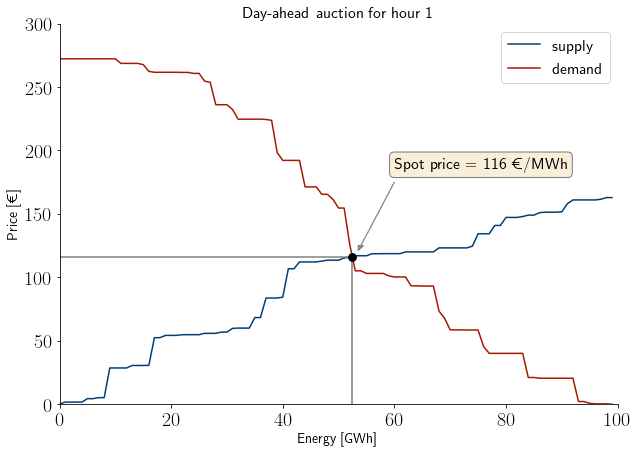

In [7]:
plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_range, supply, label="supply", zorder=1, color=ImperialColors.blue.value)
ax.plot(x_range, demand, label="demand", zorder=1, color=ImperialColors.brick.value)
ax.axvline(x=52.4, color="grey", alpha=1, ymax=0.385, zorder=1)
ax.axhline(y=116, color="grey", alpha=1, xmax=0.52, zorder=1)
ax.scatter(x=52.375, y=116.2, label=None, zorder=2, color="black", marker="o", s=60)


props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax.text(0.6, 0.65, "Spot price = 116 €/MWh ", transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=props)

ax.arrow(60, 175, -6, -50, head_width=1, head_length=4, fc='k', ec='k', alpha=0.4)
ax.tick_params(axis='both', labelsize=20)


ax.set_ylim(0, 300)
ax.set_xlim(0, 100)

ax.set_xlabel("Energy [GWh]", fontsize=14)
ax.set_ylabel("Price [€]", fontsize=14)
ax.set_title("Day-ahead auction for hour 1", fontsize=16)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(prop={"size": 16})
fig.savefig("figures/hourly_auction.pdf")
plt.rcParams['text.usetex'] = False

### Spot price timeseries

In [8]:
df = pd.read_csv("day_ahead_market_20211005.csv")
df["spain"] = df["spain"].round(decimals=2)

In [9]:
ts_index = (pd.to_datetime(df["date"]) + pd.to_timedelta(df["hour"] - 1, unit="H"))
ts_df = pd.DataFrame(index=ts_index, data=df["spain"].values)

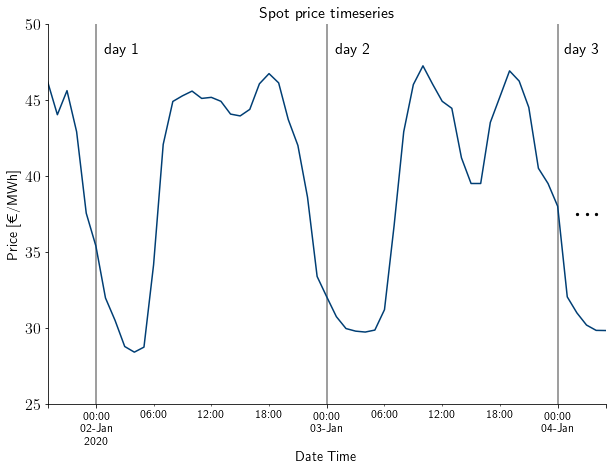

In [10]:
plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots(figsize=(10, 7))

ts_df.iloc[-15436:-15377].plot(ax=ax,ls="-", legend=False, zorder=2, color=ImperialColors.blue.value)
for i in range(1, 4):
    ax.axvline(x=ax.get_xticks()[i], zorder=1, color="grey", alpha=1)
    
ax.text(0.1, 0.95, "day 1", transform=ax.transAxes, fontsize=16,
        verticalalignment='top')

ax.text(0.515, 0.95, "day 2", transform=ax.transAxes, fontsize=16,
        verticalalignment='top')

ax.text(0.925, 0.95, "day 3", transform=ax.transAxes, fontsize=16,
        verticalalignment='top')

#ax.text(0.975, 0.5, "...", transform=ax.transAxes, fontsize=24, verticalalignment='top')

ax.scatter(x=[ax.get_xticks()[-2] + i for i in range(2, 5)], 
           y=[ax.get_yticks()[len(ax.get_yticks())//2]]*3, color="k", s=5)

ax.tick_params(axis='y', which="both", labelsize=16)
ax.tick_params(axis='x', which="both", labelsize=12)

ax.set_ylim(25, 50)

ax.set_xlabel("Date Time", fontsize=14)
ax.set_ylabel("Price [€/MWh]", fontsize=14)
ax.set_title("Spot price timeseries", fontsize=16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.savefig("figures/spot_price_ts.pdf")
plt.rcParams['text.usetex'] = False

### Wienner process

In [11]:
def generate_sample_path(n, x1, x2, p, seed):
    np.random.seed(seed)
    delta_t = 1/n
    x = np.random.choice([x1, x2], p=[p, 1-p], size=n)
    x = np.concatenate(([0], x))
    return np.cumsum(x)*np.sqrt(delta_t)

/var/folders/n4/4pcf4gm94bsfkqcmfpznj3nh0000gp/T/ipykernel_19550/3999764044.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks() / 1000)


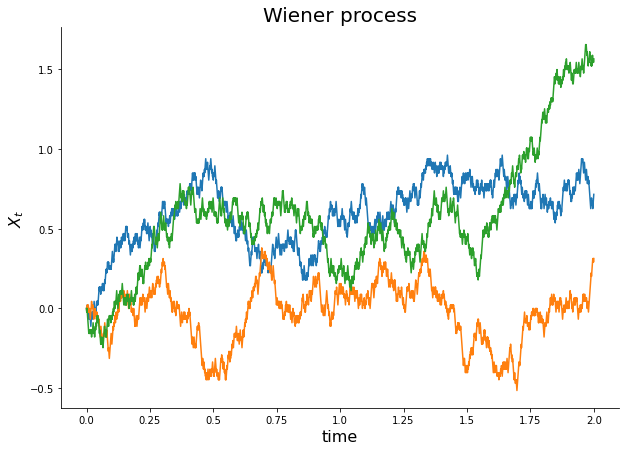

In [12]:
w = generate_sample_path(2000, x1=-1, x2=1, p=0.5, seed=124)
x = generate_sample_path(2000, x1=-1, x2=1, p=0.5, seed=72)
y = generate_sample_path(2000, x1=-1, x2=1, p=0.5, seed=1)

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(np.arange(w.shape[0]), w)
ax.plot(np.arange(x.shape[0]), x)
ax.plot(np.arange(y.shape[0]), y)

ax.set_ylabel("$X_t$",  fontsize=16)
ax.set_xlabel("time",  fontsize=16)
ax.set_title("Wiener process", fontsize=20)

ax.set_xticklabels(ax.get_xticks() / 1000)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.savefig("figures/wiener_process.pdf")

### 24 timeseries

In [13]:
df_list = []
for h in range(1, 25):
    y = df.query(f"hour == {h} & year == 2020").iloc[:50]["spain"].values
    df_hour = pd.DataFrame({"t": np.arange(y.shape[0]), "y": y})
    df_hour["hour"] = h
    
    df_list.append(df_hour)

In [14]:
df_ts = pd.concat(df_list)

/var/folders/n4/4pcf4gm94bsfkqcmfpznj3nh0000gp/T/ipykernel_19550/769354117.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


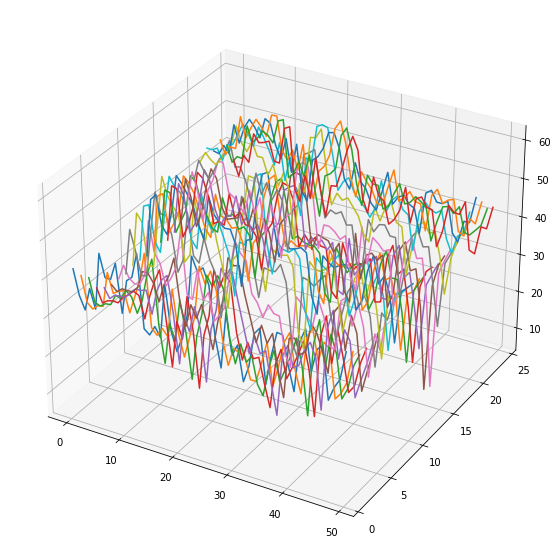

In [15]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))
for h in range(1, 25):
    aux_df = df_ts.query(f"hour == {h}")
    ax.plot(aux_df.iloc[:, 0], aux_df.iloc[:, 2], aux_df.iloc[:, 1])
fig.show()

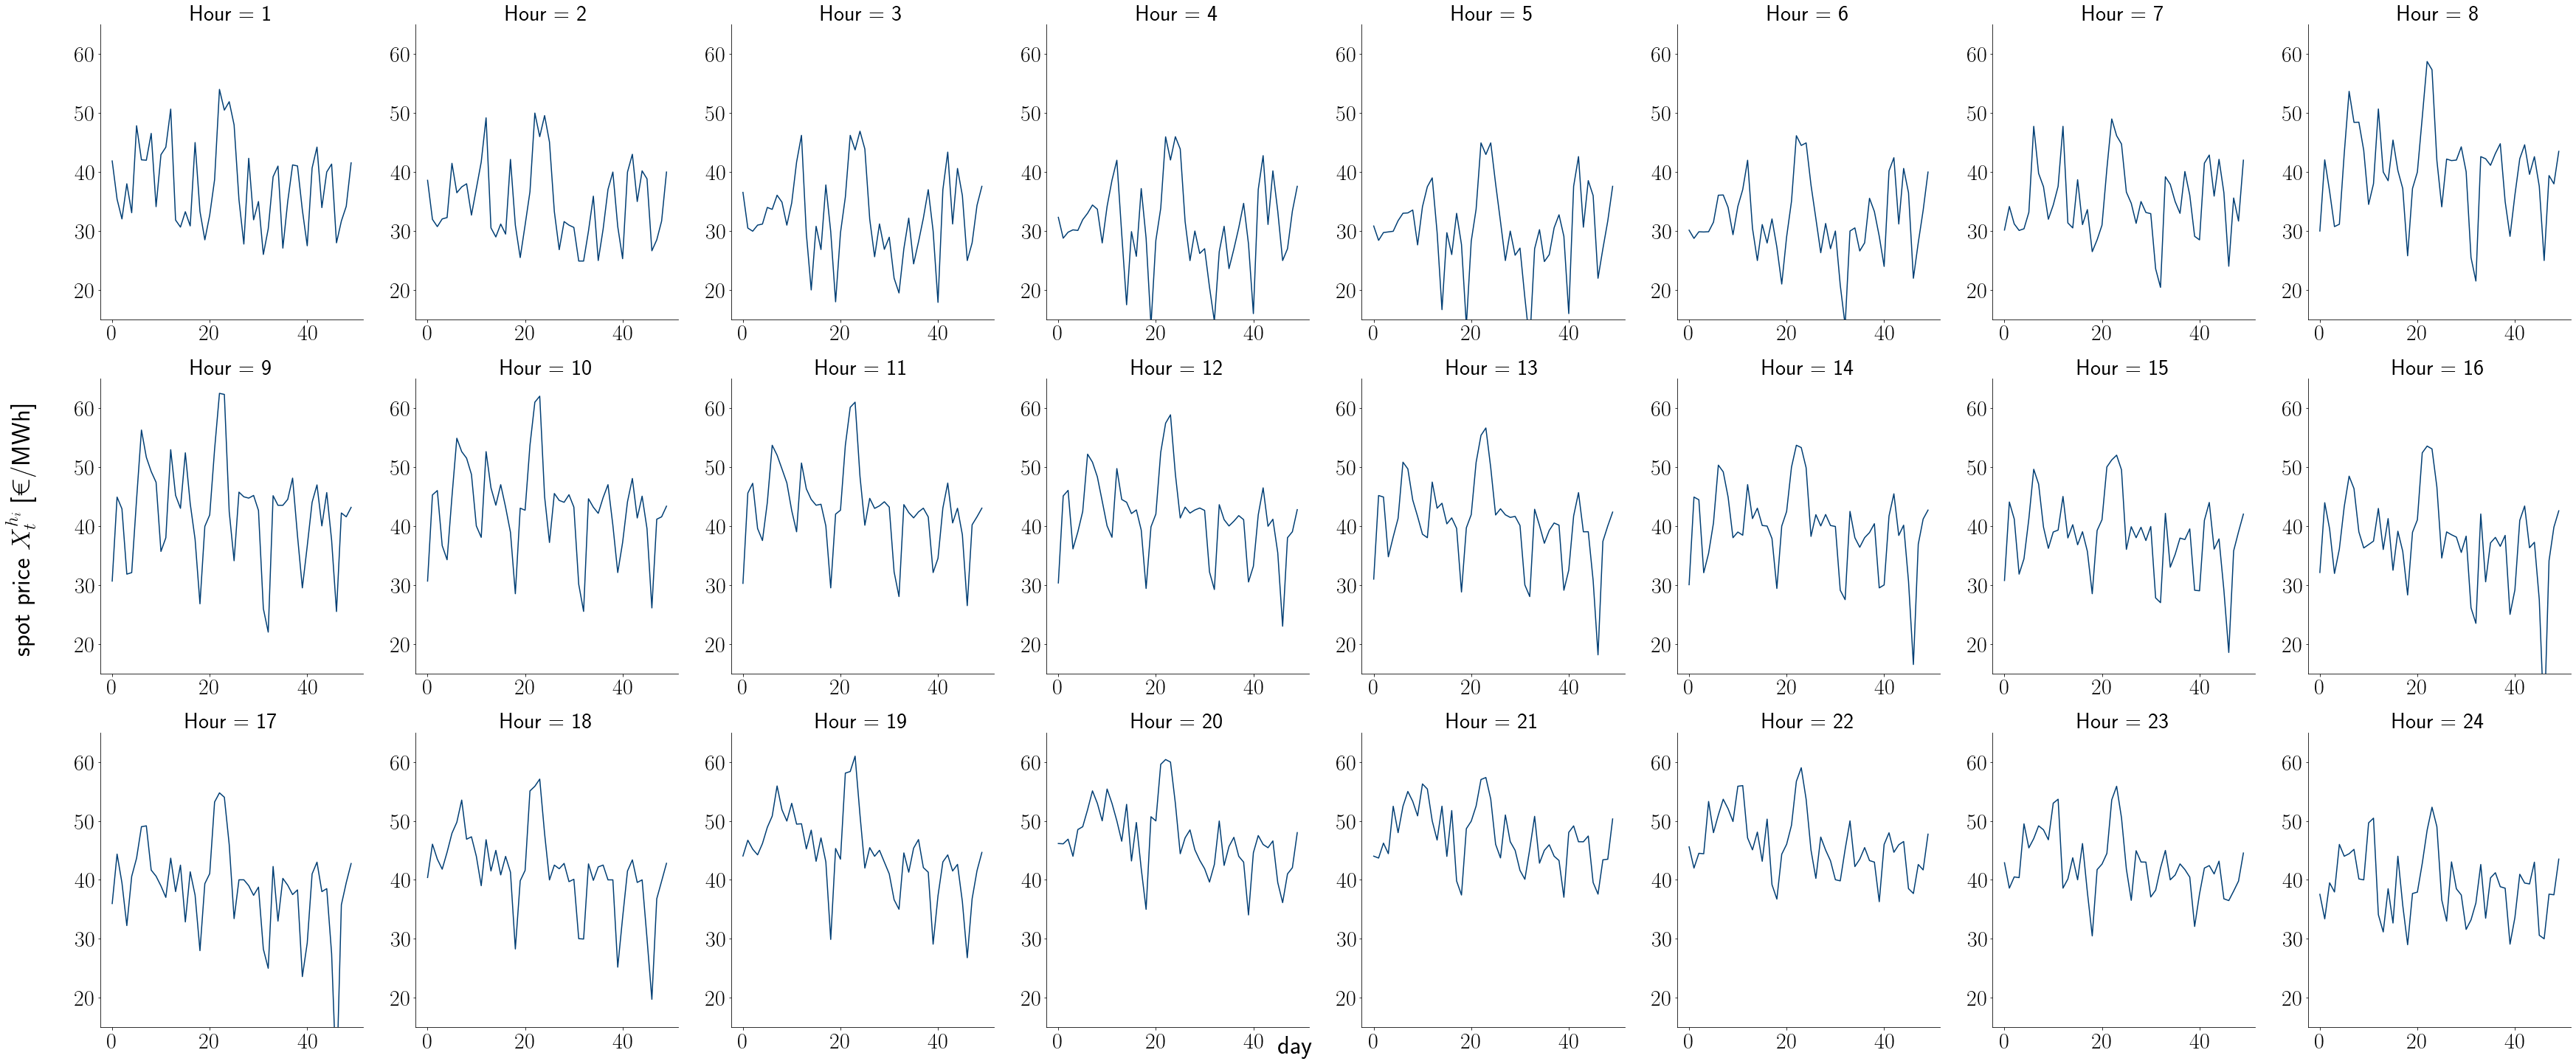

In [16]:
plt.rcParams['text.usetex'] = True
fig, axis = plt.subplots(3, 8, figsize=(60, 25))

xnew = np.arange(0, 150) 
for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*8+j
        aux_df = df_ts.query(f" hour == {h}")
        ax.plot(aux_df.iloc[:, 0] , aux_df.iloc[:, 1], color=ImperialColors.blue.value)
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=30)
        ax.set_ylim(15, 65)
        ax.tick_params(axis='both', labelsize=30)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
fig.text(0.5, 0.11, "day", ha="center", va="center", fontdict={"size": 35})
fig.text(0.1, 0.5, "spot price $X_{t}^{h_i}$ [€/MWh]", ha="center", va="center",
         fontdict={"size": 35}, rotation=90)

fig.savefig("figures/24_spot_price_ts.pdf")
plt.rcParams['text.usetex'] = False

### Seasonal patterns

In [17]:
df = pd.read_csv("day_ahead_market_20211005.csv")
df = df.query("year >= 2018 and year < 2021")
ts_index = (pd.to_datetime(df["date"]) + pd.to_timedelta(df["hour"] - 1, unit="H"))
ts_df = pd.DataFrame(index=ts_index, data=df["spain"].values)

In [18]:
from matplotlib.patches import Ellipse

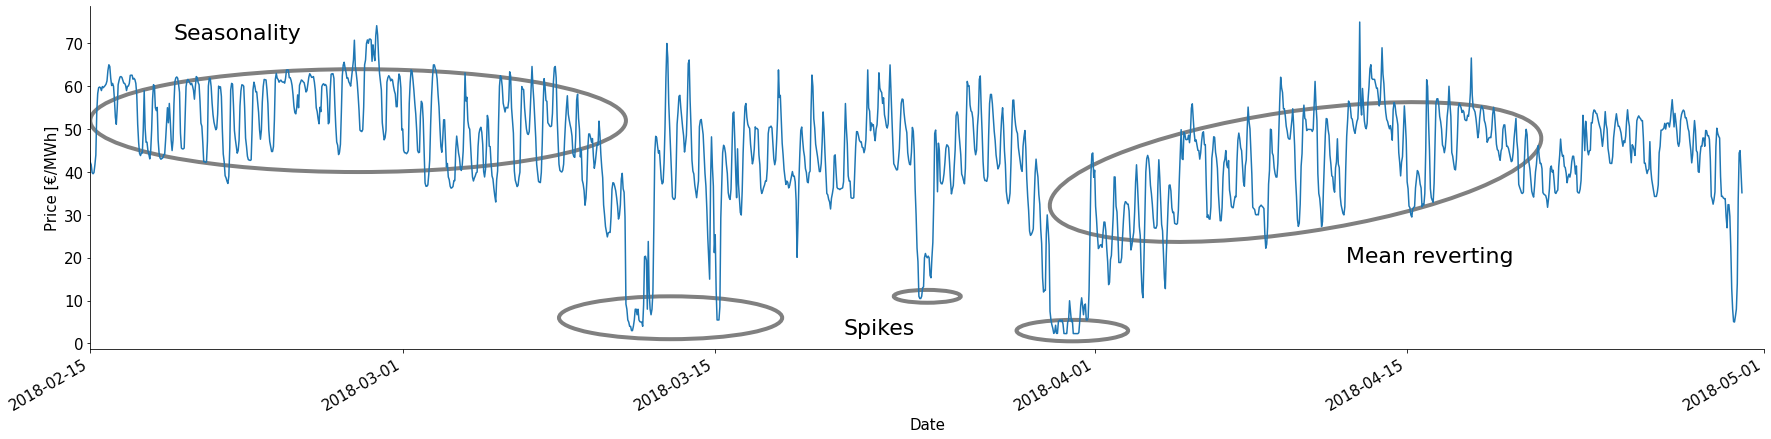

In [19]:
fig, ax = plt.subplots(figsize=(30, 7))

circle1 = plt.Circle((17589, 52), 12, color='grey', fill=False, lw=4)
circle2 = plt.Circle((17603, 6), 5, color='grey', fill=False, lw=4)
circle3 = plt.Circle((17621, 3), 2.5, color='grey', fill=False, lw=4)
circle4 = plt.Circle((17614.5, 11), 1.5, color='grey', fill=False, lw=4)
ellipse = Ellipse(xy=(17631, 40), width=35, height=18, angle=65, 
                        color='grey', fc='None', lw=4)

ts_df.iloc[24*7*5:24*7*17].plot(ax=ax,ls="-", legend=False, zorder=2)

#ax.axhline(y=ts_df.iloc[24*7:24*7*10].mean()[0])

ax.set_xlim(17577.0, 17652)

ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("Price [€/MWh]", fontsize=15)
ax.tick_params(axis='both', labelsize=15)
#ax.set_title("Spot price timeseries", fontsize=16)

ax.add_patch(circle1)
ax.text(0.05, 0.95, "Seasonality", transform=ax.transAxes, fontsize=22,
        verticalalignment='top')

ax.add_patch(circle2)
ax.add_patch(circle3)
ax.add_patch(circle4)
ax.text(0.45, 0.09, "Spikes", transform=ax.transAxes, fontsize=22,
        verticalalignment='top')

ax.add_patch(ellipse)
ax.text(0.75, 0.3, "Mean reverting", transform=ax.transAxes, fontsize=22,
        verticalalignment='top')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.savefig("figures/price_features.pdf")

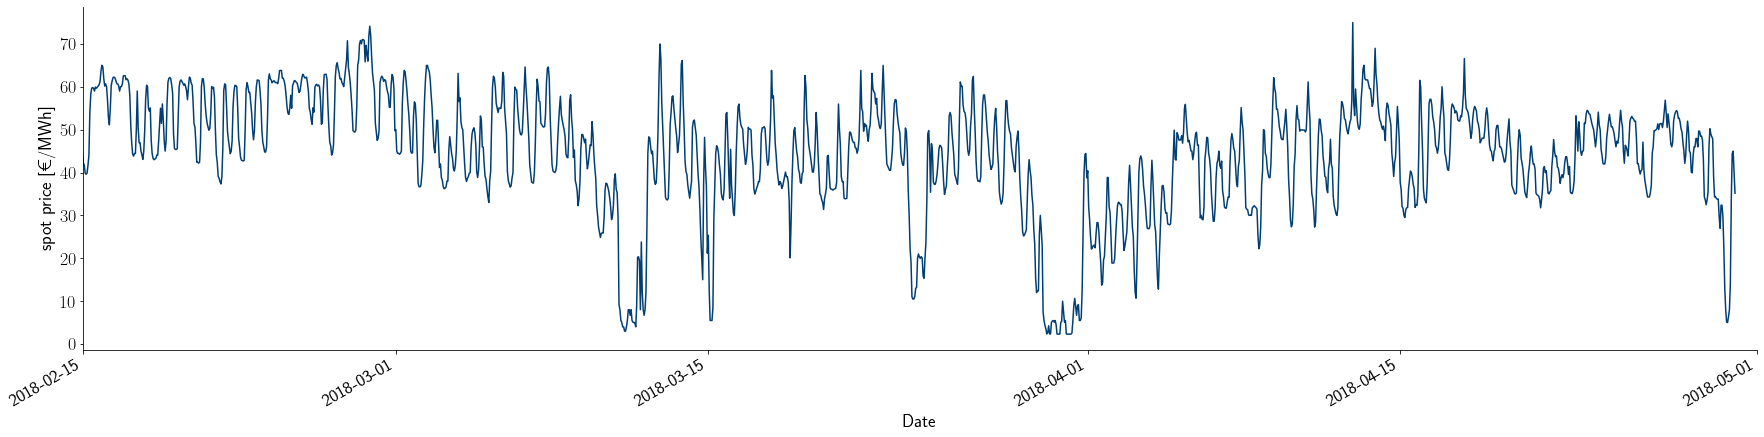

In [20]:
plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots(figsize=(30, 7))

ts_df.iloc[24*7*5:24*7*17].plot(ax=ax,ls="-", legend=False, zorder=2, color=ImperialColors.blue.value)

ax.set_xlim(17577.0, 17652)

ax.set_xlabel("Date", fontsize=18)
ax.set_ylabel(r"spot price [€/MWh]", fontsize=18)
ax.tick_params(axis='both', labelsize=18)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("figures/price_ts.pdf")
plt.rcParams['text.usetex'] = False